In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back to string
    return ' '.join(tokens)

In [4]:
df = pd.read_csv('/content/website_classification.csv')

In [5]:
df['cleaned_website_text'] = df['cleaned_website_text'].apply(preprocess_text)

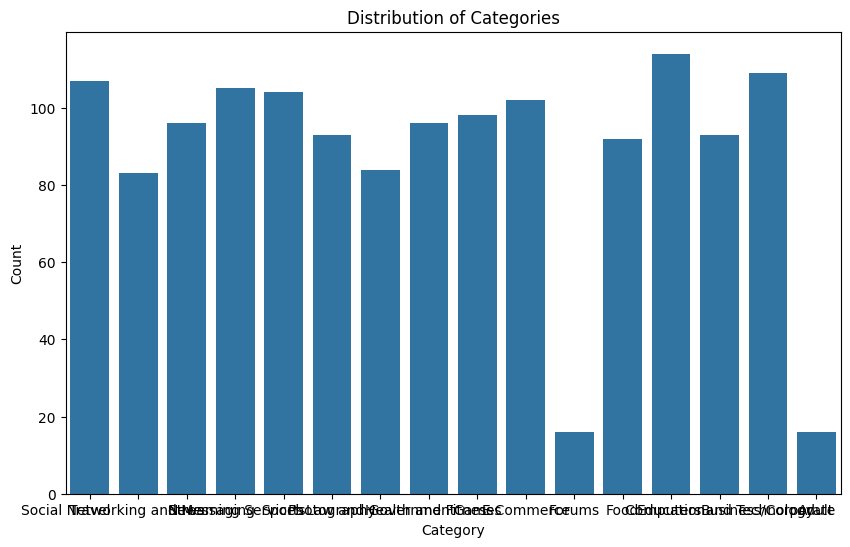

In [6]:
# Distribution of Categories
plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=df)
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


In [7]:
# Filter out the rows with 'adult' and 'forums' categories
df_filtered = df[~df['Category'].isin(['Adult', 'Forums'])]

# Verify the filtering
print(df_filtered['Category'].value_counts())


Category
Education                          114
Business/Corporate                 109
Travel                             107
Streaming Services                 105
Sports                             104
E-Commerce                         102
Games                               98
News                                96
Health and Fitness                  96
Photography                         93
Computers and Technology            93
Food                                92
Law and Government                  84
Social Networking and Messaging     83
Name: count, dtype: int64


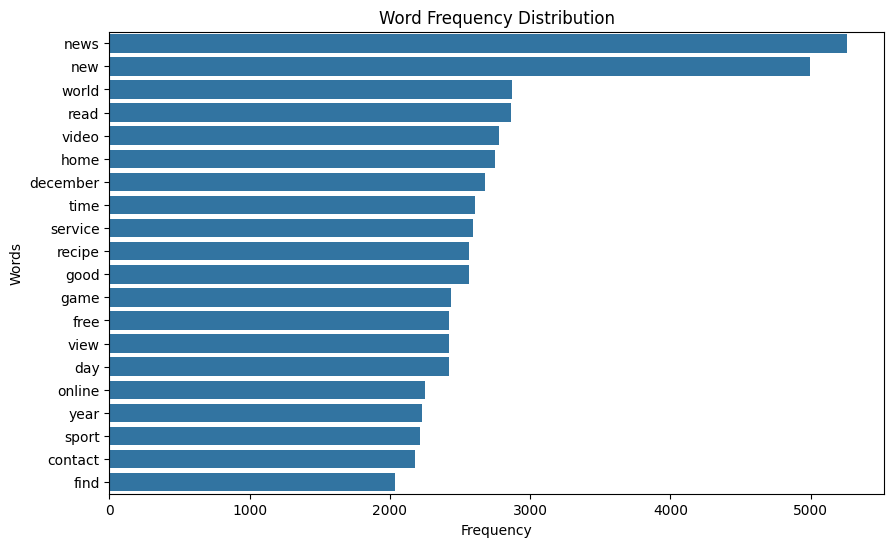

In [8]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Get word frequency
word_counts = Counter(' '.join(df_filtered['cleaned_website_text']).split())
common_words = word_counts.most_common(20)

# Data for plot
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words)
plt.title('Word Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


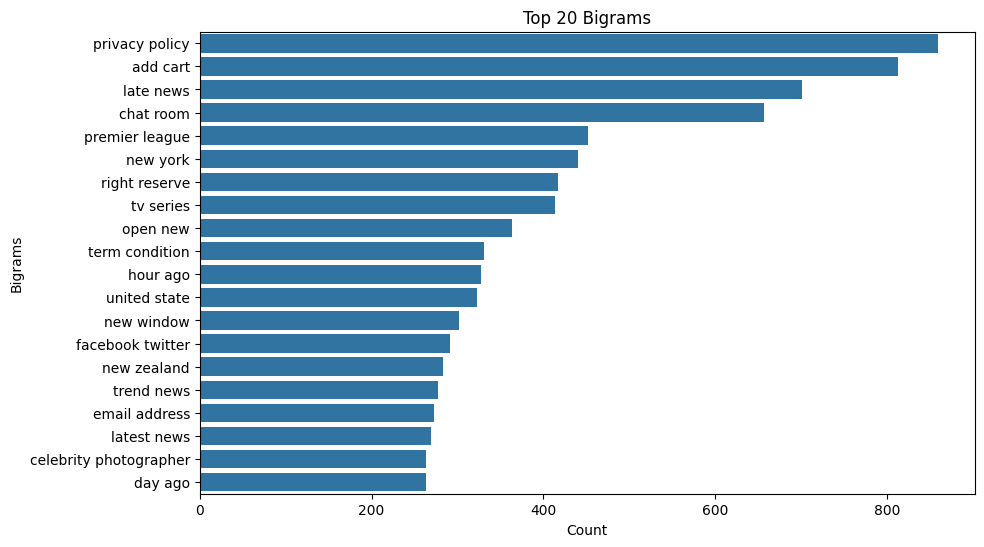

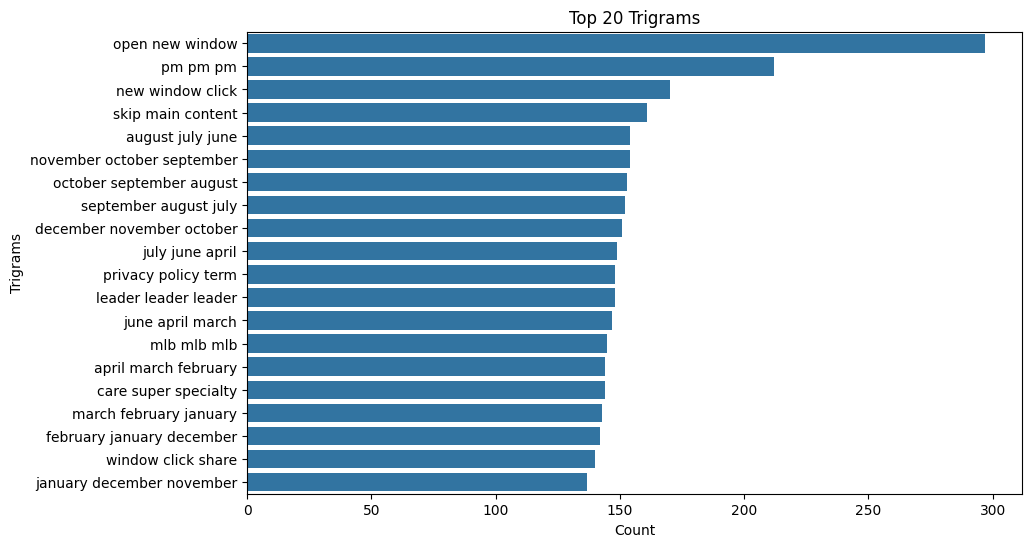

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Bigrams for df_filtered
vectorizer = CountVectorizer(ngram_range=(2, 2))
X_bigrams = vectorizer.fit_transform(df_filtered['cleaned_website_text'])
bigram_counts = sum(X_bigrams).toarray()[0]
bigrams = vectorizer.get_feature_names_out()

bigram_data = pd.DataFrame({'bigram': bigrams, 'count': bigram_counts})
bigram_data = bigram_data.sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='bigram', data=bigram_data)
plt.title('Top 20 Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigrams')
plt.show()

# Trigrams for df_filtered
vectorizer = CountVectorizer(ngram_range=(3, 3))
X_trigrams = vectorizer.fit_transform(df_filtered['cleaned_website_text'])
trigram_counts = sum(X_trigrams).toarray()[0]
trigrams = vectorizer.get_feature_names_out()

trigram_data = pd.DataFrame({'trigram': trigrams, 'count': trigram_counts})
trigram_data = trigram_data.sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='trigram', data=trigram_data)
plt.title('Top 20 Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigrams')
plt.show()


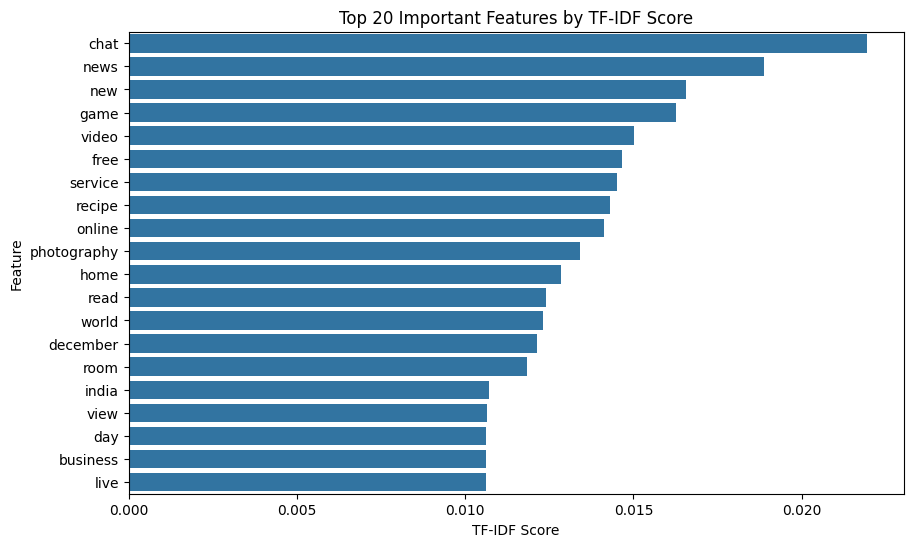

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Fit TF-IDF vectorizer on df_filtered
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df_filtered['cleaned_website_text'])

# Get feature names and their TF-IDF scores
tfidf_scores = np.asarray(X_tfidf.mean(axis=0)).flatten()
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame for TF-IDF scores
tfidf_data = pd.DataFrame({'feature': feature_names, 'tfidf_score': tfidf_scores})
tfidf_data = tfidf_data.sort_values(by='tfidf_score', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf_score', y='feature', data=tfidf_data)
plt.title('Top 20 Important Features by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Feature')
plt.show()


In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_filtered['Category'] = label_encoder.fit_transform(df_filtered['Category'])

<ipython-input-10-0748e73aadcc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Category'] = label_encoder.fit_transform(df_filtered['Category'])


In [11]:
X = df_filtered['cleaned_website_text']
y = df_filtered['Category']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# Best parameters
knn_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='uniform'))
])

# Train and predict
knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'K-Nearest Neighbor - Accuracy: {accuracy_knn:.2f}')
print(classification_report(y_test, y_pred_knn))


K-Nearest Neighbor - Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.77      0.85        22
           1       0.83      0.79      0.81        19
           2       0.95      0.95      0.95        21
           3       0.88      1.00      0.93        21
           4       1.00      1.00      1.00        25
           5       0.94      0.94      0.94        18
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        22
           8       0.95      0.88      0.91        24
           9       0.86      0.95      0.90        19
          10       0.80      0.67      0.73        12
          11       1.00      1.00      1.00        24
          12       0.84      1.00      0.91        16
          13       0.95      1.00      0.97        19

    accuracy                           0.93       276
   macro avg       0.93      0.92      0.92       276
weighted avg       0.93      0.93      0.93 

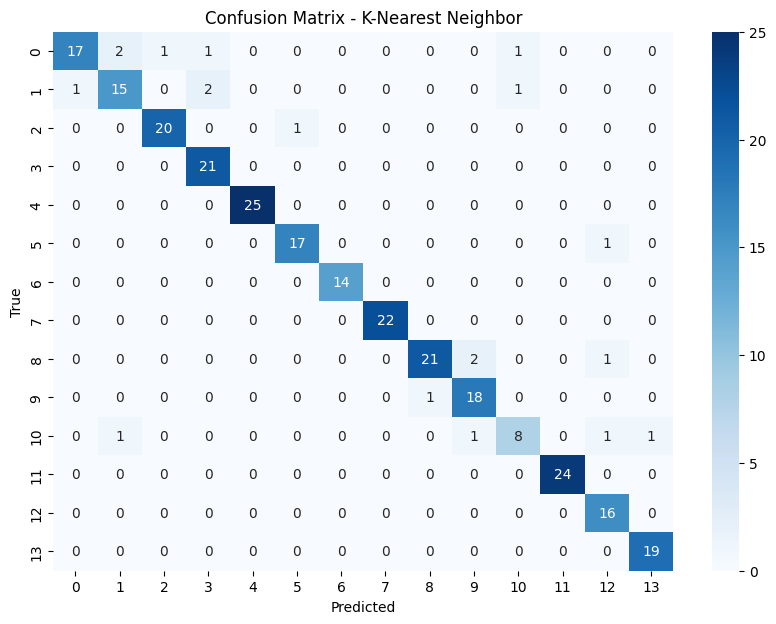

In [14]:
# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - K-Nearest Neighbor')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

log_reg = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='saga')
log_reg.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_log_reg = log_reg.predict(X_test_tfidf)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression - Accuracy: {accuracy_log_reg:.2f}')
print(classification_report(y_test, y_pred_log_reg))


Logistic Regression - Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        22
           1       0.77      0.89      0.83        19
           2       1.00      0.95      0.98        21
           3       0.95      1.00      0.98        21
           4       1.00      0.96      0.98        25
           5       0.94      0.94      0.94        18
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        22
           8       0.96      0.96      0.96        24
           9       0.94      0.89      0.92        19
          10       0.90      0.75      0.82        12
          11       0.96      0.96      0.96        24
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        19

    accuracy                           0.95       276
   macro avg       0.95      0.94      0.95       276
weighted avg       0.95      0.95      0.95

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


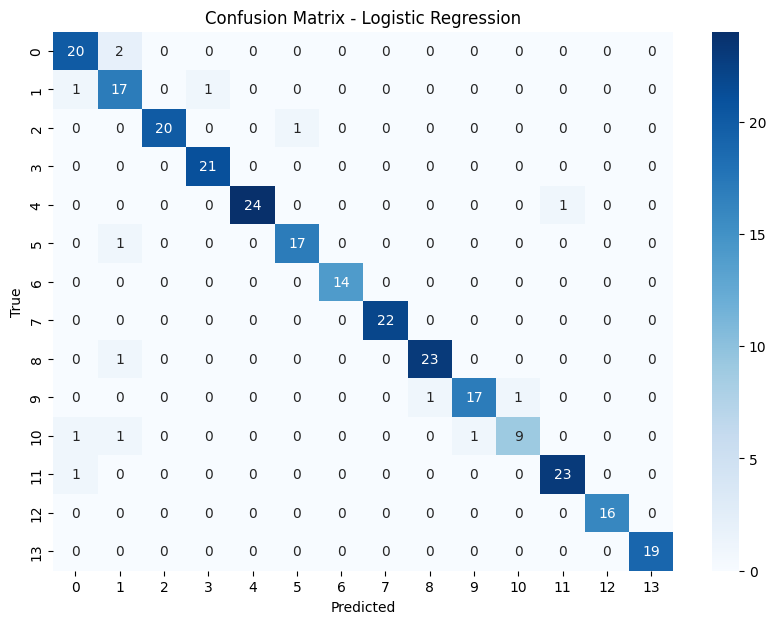

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [17]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

svc = SVC(C=10, gamma='scale', kernel='linear')
svc.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_svc = svc.predict(X_test_tfidf)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f'SVC - Accuracy: {accuracy_svc:.2f}')
print(classification_report(y_test, y_pred_svc))


SVC - Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.65      0.91      0.75        22
           1       0.77      0.89      0.83        19
           2       1.00      0.90      0.95        21
           3       0.95      0.95      0.95        21
           4       1.00      0.88      0.94        25
           5       0.94      0.94      0.94        18
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        22
           8       0.96      0.96      0.96        24
           9       0.94      0.89      0.92        19
          10       1.00      0.67      0.80        12
          11       0.96      0.92      0.94        24
          12       1.00      1.00      1.00        16
          13       1.00      0.95      0.97        19

    accuracy                           0.92       276
   macro avg       0.94      0.92      0.93       276
weighted avg       0.94      0.92      0.93       276



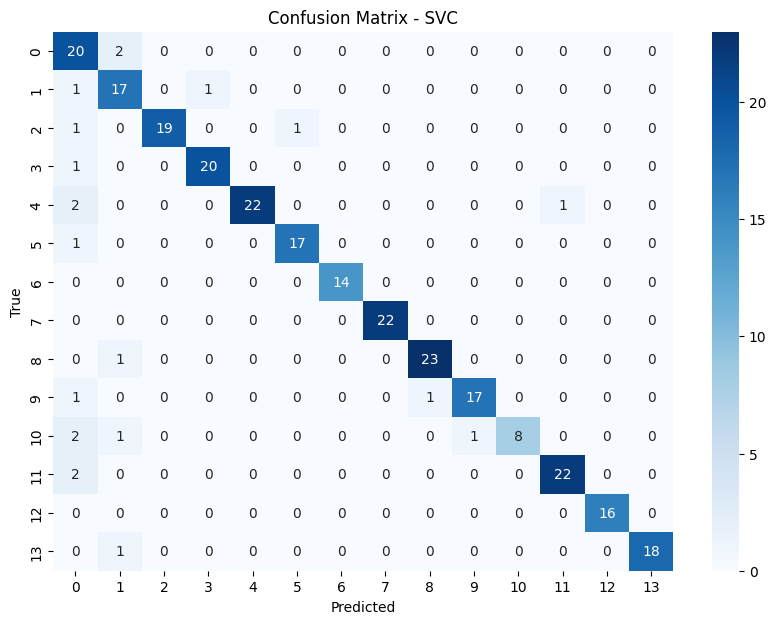

In [18]:
# Confusion Matrix for SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVC')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

nb_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 1))),
    ('classifier', MultinomialNB(alpha=0.01))
])

# Train and predict
nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes - Accuracy: {accuracy_nb:.2f}')
print(classification_report(y_test, y_pred_nb))


Naive Bayes - Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        22
           1       0.86      0.95      0.90        19
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        21
           4       0.96      0.92      0.94        25
           5       0.89      0.94      0.92        18
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        22
           8       1.00      0.96      0.98        24
           9       0.90      0.95      0.92        19
          10       1.00      0.75      0.86        12
          11       0.96      0.96      0.96        24
          12       0.89      1.00      0.94        16
          13       0.90      1.00      0.95        19

    accuracy                           0.95       276
   macro avg       0.95      0.94      0.94       276
weighted avg       0.95      0.95      0.95       2

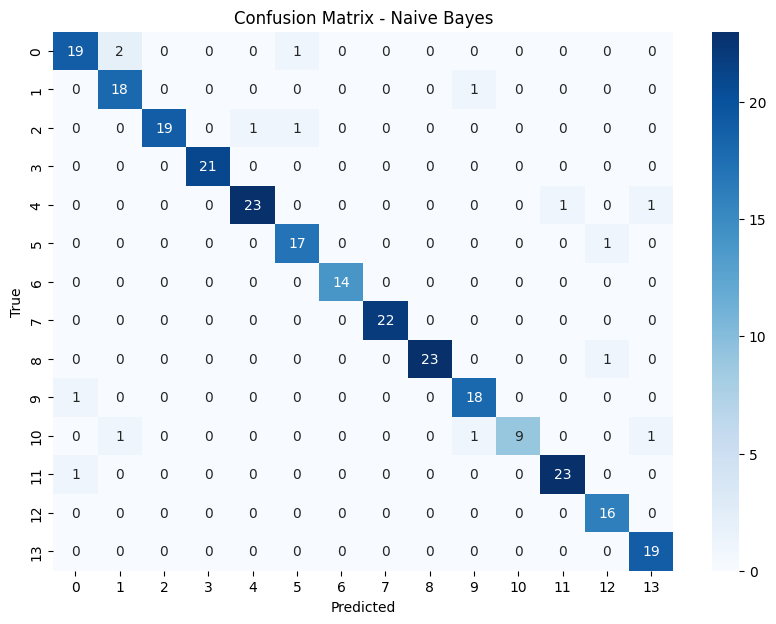

In [20]:
# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

rf_clf = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=300)
rf_clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_rf = rf_clf.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest - Accuracy: {accuracy_rf:.2f}')
print(classification_report(y_test, y_pred_rf))


Random Forest - Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.88      0.79      0.83        19
           2       0.94      0.81      0.87        21
           3       0.80      0.95      0.87        21
           4       0.88      0.84      0.86        25
           5       0.75      0.83      0.79        18
           6       1.00      0.93      0.96        14
           7       1.00      1.00      1.00        22
           8       0.92      0.96      0.94        24
           9       0.95      0.95      0.95        19
          10       1.00      0.67      0.80        12
          11       0.96      1.00      0.98        24
          12       0.88      0.94      0.91        16
          13       0.90      1.00      0.95        19

    accuracy                           0.91       276
   macro avg       0.91      0.90      0.90       276
weighted avg       0.91      0.91      0.90      

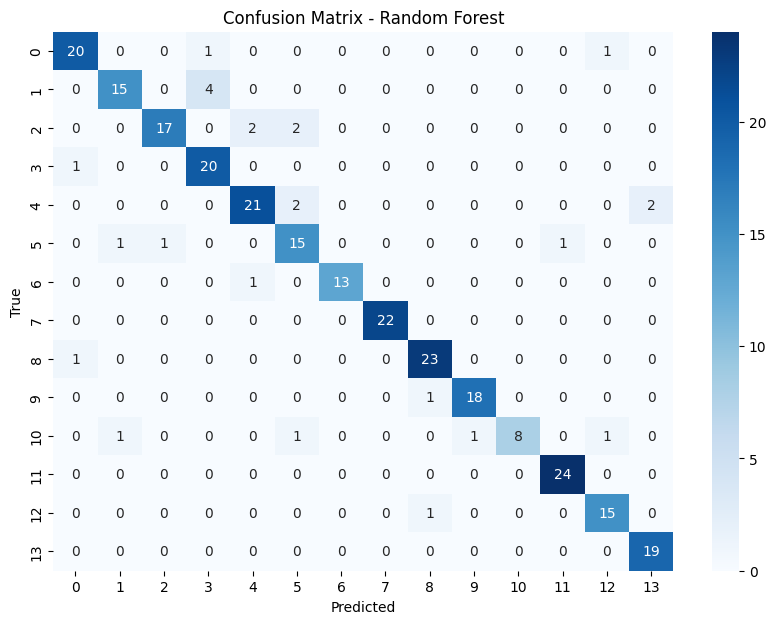

In [22]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


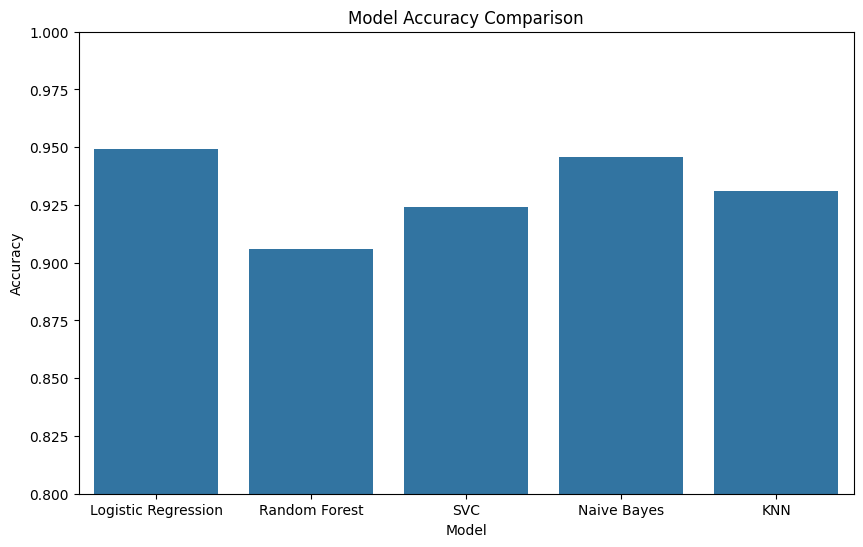

In [23]:
import matplotlib.pyplot as plt

# Bar plot for accuracies
accuracy_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVC', 'Naive Bayes', 'KNN'],
    'Accuracy': [accuracy_log_reg, accuracy_rf, accuracy_svc, accuracy_nb, accuracy_knn]
}
accuracy_df = pd.DataFrame(accuracy_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Adjust the y-axis limits if needed
plt.show()
